## PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:
1. Detección y eliminación de Outliers
1. Encoding
1. Imputación de valores faltantes
1. Escalado de datos

1. Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import shap

from pandas_profiling import ProfileReport
import plotly.graph_objects as go
import plotly.express as px
# import plotly.plotly as py
from plotly.graph_objs import *
pd.options.mode.chained_assignment = None  # default='warn'
from pycaret.regression import *



sns.set()

In [3]:
# EXTRA FORMATO TEXTO
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [4]:
def diferencia_instancias(inicial_,final_):
    return print('Cantidad de instancias inciales', inicial_.shape[0], ', cantidad de instancias finales', final_.shape[0], 
      'y la cantidad de instancias eliminadas es', (inicial_.shape[0] - final_.shape[0]))
def diferencia_columnas(inicial_,final_):
    if ((inicial_.shape[1] - final_.shape[1]) >= 0):
        return print('Cantidad de columnas inciales', inicial_.shape[1], ', cantidad de columnas finales', final_.shape[1], 
          'y la cantidad de columnas eliminadas es', (inicial_.shape[1] - final_.shape[1]))
    return print('Cantidad de columnas inciales', inicial_.shape[1], ', cantidad de columnas finales', final_.shape[1], 
      'y la diferencia de columnas es', (final_.shape[1] - inicial_.shape[1]))

In [5]:
#Ruta donde se va a leer el dataset
path= 'DS_Proyecto_01_Datos_Properati.csv'
#Se le asigna a una variable de python el dataset por medio de la funcion de Pandas "read_csv()"
dataset = pd.read_csv(path)

print('El dataset tiene', dataset.shape[0], 'filas')
print('El dataset tiene', dataset.shape[1], 'columnas')

# prof_1 = ProfileReport(dataset)
# prof_1.to_file(output_file='dataset_inicial.html')
# prof_1

El dataset tiene 146660 filas
El dataset tiene 19 columnas


In [6]:
print('Nombres de las columnas y valores faltantes por columna:')
dataset.isnull().sum()

Nombres de las columnas y valores faltantes por columna:


start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

In [7]:
# Transformacion 1
dataset_1 = dataset.drop_duplicates()
diferencia_instancias(dataset, dataset_1)


Cantidad de instancias inciales 146660 , cantidad de instancias finales 144302 y la cantidad de instancias eliminadas es 2358


In [8]:
# Transformacion 2

var_0='property_type'
var_1='l2'
var_2='l3'
var_0_top=dataset_1[var_0].value_counts()[:3].index.tolist() # filtro tipo de propiedad es Departamento, PH o Casa
var_1_top=dataset_1[var_1].value_counts()[:1].index.tolist() # filtro propiedades en Capital Federal

dataset_2_=dataset_1.loc[(dataset_1[var_0].isin(var_0_top))&(dataset_1[var_1].isin(var_1_top))]

var_2_top=dataset_2_[var_2].value_counts()[:15].index.tolist() # filtro propiedades en los principales 15 barrios
dataset_2=dataset_2_.loc[(dataset_2_[var_2].isin(var_2_top))]

diferencia_instancias(dataset_1, dataset_2)

Cantidad de instancias inciales 144302 , cantidad de instancias finales 65208 y la cantidad de instancias eliminadas es 79094


In [9]:
# Transformacion 3

dataset_3 = dataset_2[(dataset_2.surface_total >= 15)&(dataset_2.surface_total <= 1000)]
diferencia_instancias(dataset_2, dataset_3)

Cantidad de instancias inciales 65208 , cantidad de instancias finales 59343 y la cantidad de instancias eliminadas es 5865


In [10]:
# Transformacion 4

dataset_4 = dataset_3[(dataset_3.price <= 4000000)]
diferencia_instancias(dataset_3, dataset_4)

Cantidad de instancias inciales 59343 , cantidad de instancias finales 59312 y la cantidad de instancias eliminadas es 31


In [11]:
# Transformacion 5

dataset_5 = dataset_4[(dataset_4.surface_covered <= dataset_4.surface_total)]
diferencia_instancias(dataset_4, dataset_5)

Cantidad de instancias inciales 59312 , cantidad de instancias finales 58608 y la cantidad de instancias eliminadas es 704


In [12]:
# Transformacion 6

Q1 = dataset_5.quantile(0.25)
Q3 = dataset_5.quantile(0.75)
IQR = Q3 - Q1
dataset_6 = dataset_5[~ ((dataset_5 < (Q1 - 1.5 * IQR)) | (dataset_5> (Q3 + 1.5 * IQR))).any(axis=1)]
diferencia_instancias(dataset_5, dataset_6)

Cantidad de instancias inciales 58608 , cantidad de instancias finales 49894 y la cantidad de instancias eliminadas es 8714


In [13]:
# Transformacion 7

valores_medios_bano = dict(dataset_6.groupby('property_type')['bathrooms'].agg(pd.Series.mode))
dataset_6.bathrooms = dataset_6.bathrooms.fillna(dataset_6.property_type.map(valores_medios_bano))

In [14]:
# Transformacion 8

dataset_7 = dataset_6[['l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]
diferencia_columnas(dataset_6, dataset_7)

Cantidad de columnas inciales 19 , cantidad de columnas finales 8 y la cantidad de columnas eliminadas es 11


In [15]:
dataset_8 = dataset_7.reset_index(drop=True)

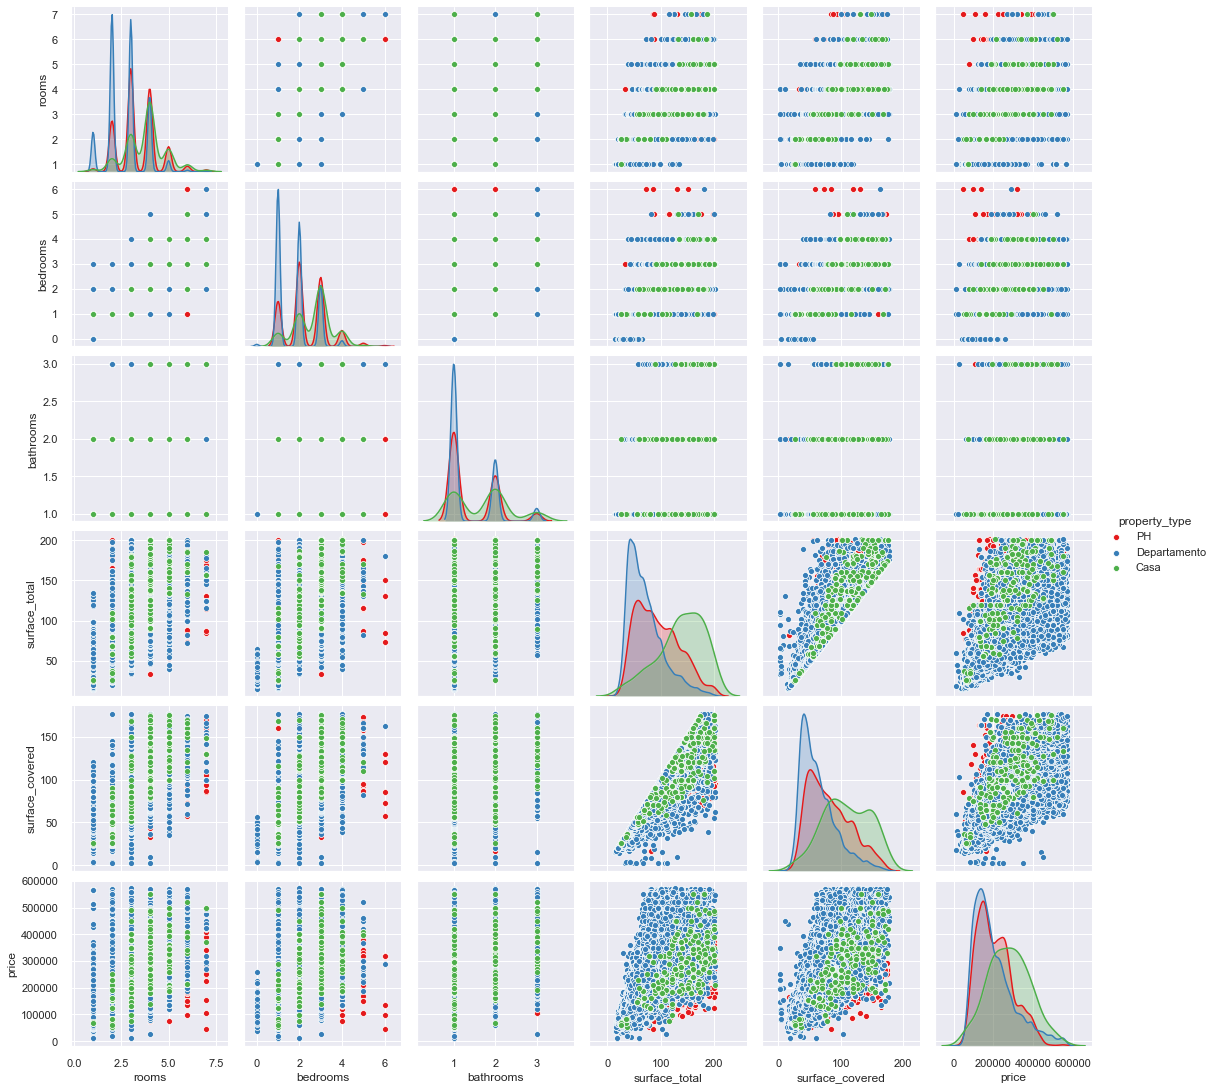

In [16]:
# fig = px.scatter_matrix(dataset_8)
sns.pairplot(dataset_8, hue='property_type', palette='Set1')

In [17]:
# prof_2 = ProfileReport(dataset_8)
# prof_2.to_file(output_file='dataset_final.html')
# prof_2

In [18]:
dataset_9 = pd.get_dummies(dataset_8, columns=['property_type', 'l3'])
diferencia_columnas(dataset_8, dataset_9)

Cantidad de columnas inciales 8 , cantidad de columnas finales 24 y la diferencia de columnas es 16


In [19]:
X = dataset_9.loc[:, dataset_9.columns != 'price']
y = dataset_9['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## PCA

In [20]:
# PCA y Split test train standar
pca = PCA(n_components=0.9).fit(X_train_std)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

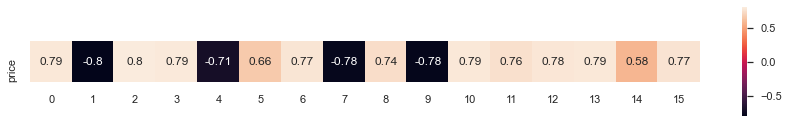

In [21]:
corr = pd.concat([pd.DataFrame(X_train_pca).reset_index(drop=True),  y_train.reset_index(drop=True)], axis=1).corr()
mask = np.ones_like(corr)
mask[-1] = False
mask[-1,-1] = True
f, ax = plt.subplots(figsize=(15, 2))

masked_corr = corr.loc[~np.all(mask, axis=1), ~np.all(mask, axis=0)]
sns.heatmap(masked_corr, square=True,  annot=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)


In [22]:
# data_pca = pd.concat([pd.DataFrame(X_train_pca).reset_index(drop=True),  y_train.reset_index(drop=True)], axis=1)
# reg1 = setup(data_pca, target = 'price', session_id=123, silent=True,verbose=False)
# best_pca = compare_models(fold = 5, sort = 'RMSE', turbo = True)

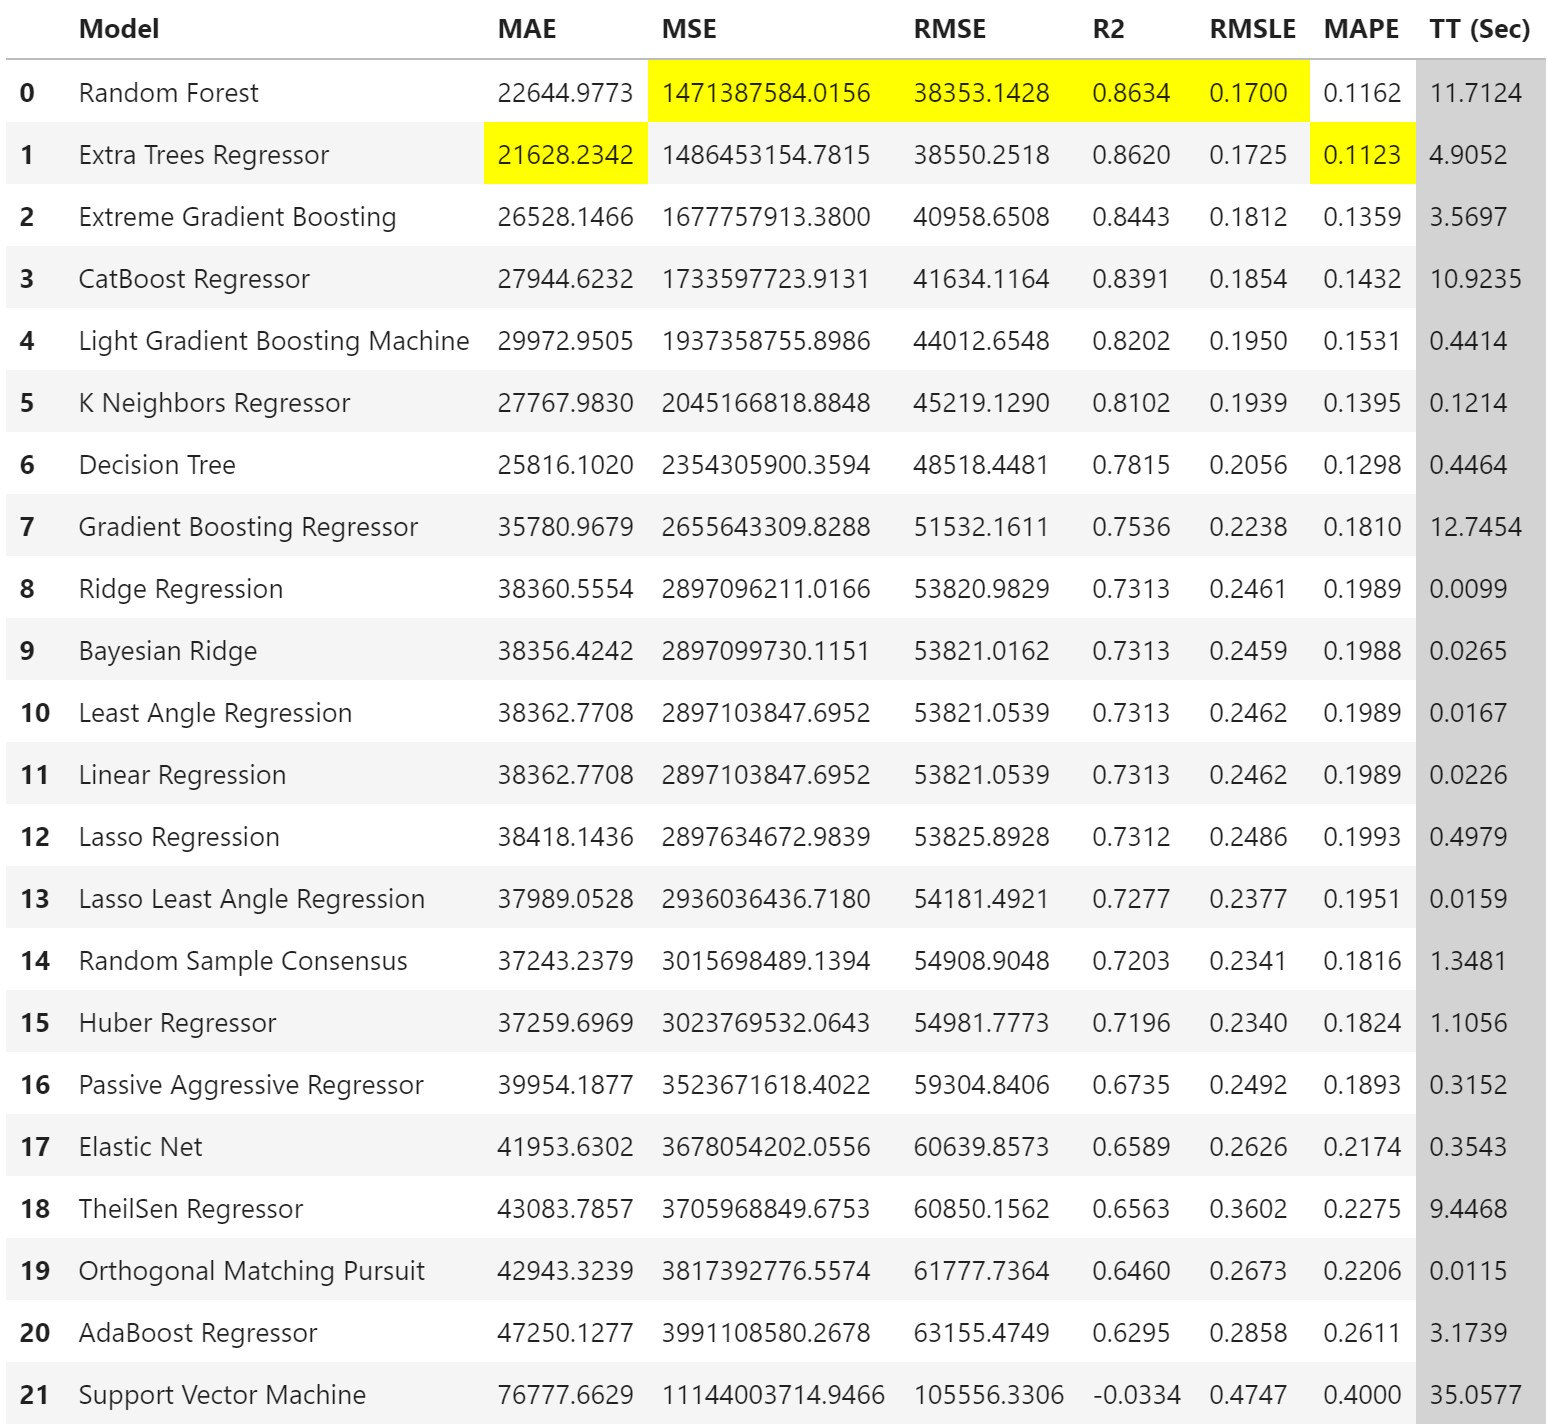

In [23]:
# data_std = pd.concat([pd.DataFrame(X_train_std).reset_index(drop=True),  y_train.reset_index(drop=True)], axis=1)
# reg1 = setup(data_std, target = 'price', session_id=123, silent=True,verbose=False)
# best_std = compare_models(fold = 5, sort = 'RMSE', turbo = True)

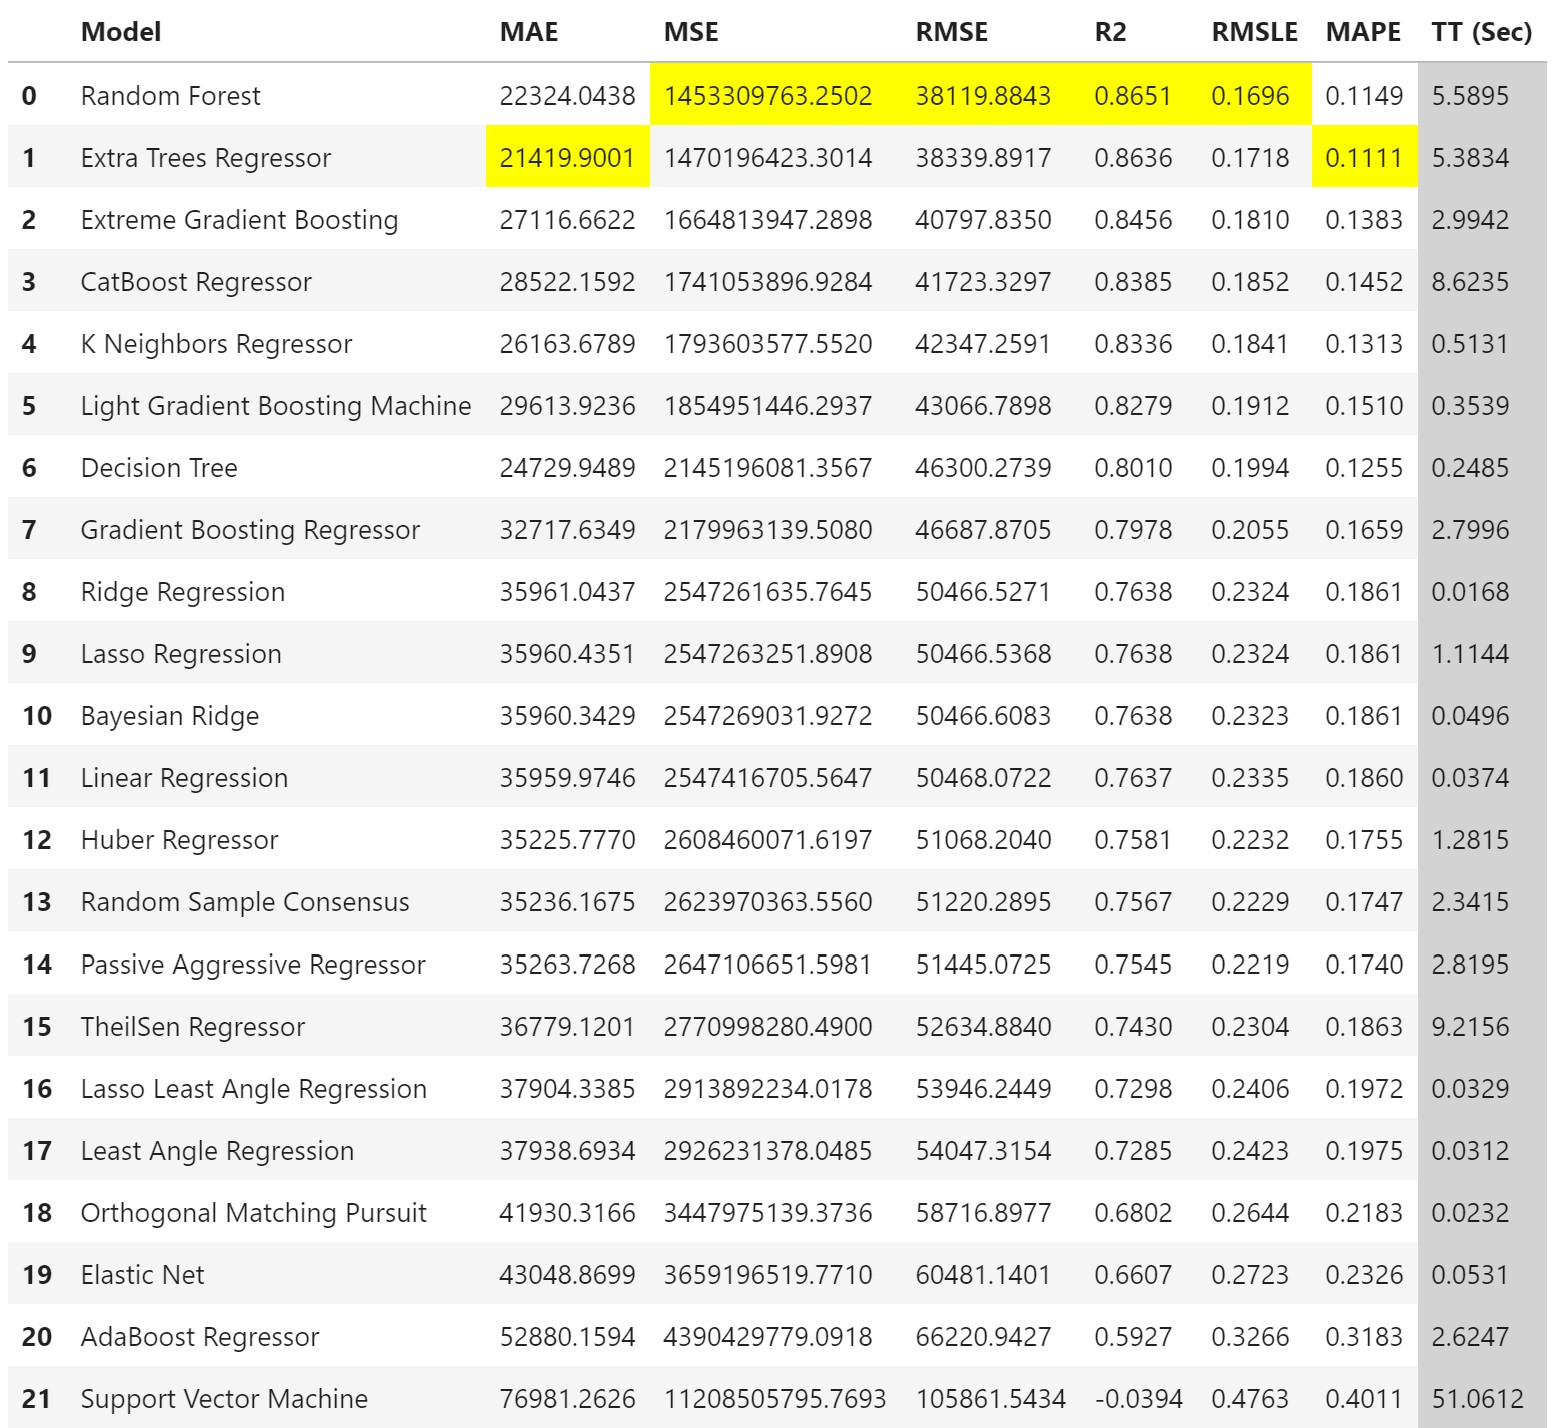

A continuacion se utiliza el modelo del primer proyecto a modo de Benchmark (PARTE A - Desempeño)

## PARTE B - Modelos Avanzados

6. Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

1. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

1. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [32]:
## Defino funcion para evaluar regresion de manera comoda

def evaluar(model_,x_,y_, X_train_, X_test_, y_train_, y_test_):
    
    y_train_pred_ = model_.predict(X_train_)
    y_test_pred_ = model_.predict(X_test_)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train_, y_train_pred_))
    rmse_test = np.sqrt(mean_squared_error(y_test_, y_test_pred_))
    
    mae_train = mean_absolute_error(y_train_, y_train_pred_)
    mae_test = mean_absolute_error(y_test_, y_test_pred_)

    r2_train = r2_score(y_train_, y_train_pred_)
    r2_test = r2_score(y_test_, y_test_pred_)
    
    print('')
    print(color.BOLD + f'Raíz del error cuadrático medio(RMSE) en Train: {rmse_train}',color.END)
    print(color.BOLD + f'Raíz del error cuadrático medio(RMSE) en Test: {rmse_test}',color.END)
    print('')

    print(f'Error absoluto medio (MAE) en Train: {mae_train}')
    print(f'Error absoluto medio (MAE) en Test: {mae_test}')
    
    print(f'R² en Train: {r2_train}')
    print(f'R² en Test: {r2_test}')
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train_ - y_train_pred_, bins = 20, label = 'train')
    sns.distplot(y_test_ - y_test_pred_, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_,y_test_pred_, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()
    
def evaluate(test_features, test_labels,predictions):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print(' ')
    print('Error Promedio: {:0.4f} dias.'.format(np.mean(errors)))
    print('Exactitud = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [35]:
# Defino funcion para testear valores de hiperparametros de manera comoda


def test_hiperparametro(model_,x_,y_, X_train_, X_test_, y_train_, y_test_, n_opciones):
    # Definimos las listas vacias para los valores de accuracy deseados
    lista_rmse_train = []
    lista_rmse_test = []
    lista_mae_train = []
    lista_mae_test = []
    lista_r2_train = []
    lista_r2_test = []
    

    # Generamos en loop sobre los distintos valores de k 
    for n in n_opciones:

        # Vamos a repetir el siguiente bloque de código

        # Definir el modelo con el valor de vecinos deseado
        if model_ == 'tree':
            clf = DecisionTreeRegressor(max_depth=n, random_state=42)
            xlabel = 'Profundidad del árbol'
        elif model_ == 'knn':
            clf = KNeighborsRegressor(n_neighbors=n)
            xlabel = 'Número de Vecinos'
        elif model_ == 'rf':
            clf = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs = 4)
            xlabel = 'Random Forest'
        else:
            print('Error: modelo no programado')


        # Entrenar el modelo
        clf.fit(X_train,y_train)

        y_train_pred_ = clf.predict(X_train)
        y_test_pred_ = clf.predict(X_test)

        test_valor_rmse = np.sqrt(mean_squared_error(y_test_, y_test_pred_))
        train_valor_rmse = np.sqrt(mean_squared_error(y_train_, y_train_pred_))
        test_valor_mae = mean_absolute_error(y_test_, y_test_pred_)
        train_valor_mae = mean_absolute_error(y_train_, y_train_pred_)        
        train_valor_r2 = r2_score(y_train_, y_train_pred_)
        test_valor_r2 = r2_score(y_test_, y_test_pred_)

        # Agregar la información a las listas
        lista_rmse_train.append(train_valor_rmse)
        lista_rmse_test.append(test_valor_rmse)
        lista_mae_train.append(train_valor_mae)
        lista_mae_test.append(test_valor_mae)
        lista_r2_train.append(train_valor_r2)
        lista_r2_test.append(test_valor_r2)

   
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (20,4))

    plt.subplot(1,3,1)
    plt.plot(n_opciones,lista_rmse_train,'o-',label='train' )
    plt.plot(n_opciones,lista_rmse_test,'o-',label='test')
    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(n_opciones,lista_mae_train,'o-',label='train' )
    plt.plot(n_opciones,lista_mae_test,'o-',label='test')
    plt.xlabel(xlabel)
    plt.ylabel('MAE')
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(n_opciones,lista_r2_train,'o-',label='train' )
    plt.plot(n_opciones,lista_r2_test,'o-',label='test')
    plt.xlabel(xlabel)
    plt.ylabel('R²')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Benchmark
Para benchmark se eligio el mejor modelo del proyecto 1


Raíz del error cuadrático medio(RMSE) en Train: 35021.639753085066 
Raíz del error cuadrático medio(RMSE) en Test: 42493.63580712596 

Error absoluto medio (MAE) en Train: 21958.153415261328
Error absoluto medio (MAE) en Test: 27070.681712911635
R² en Train: 0.8849999447536129
R² en Test: 0.8250421649101418


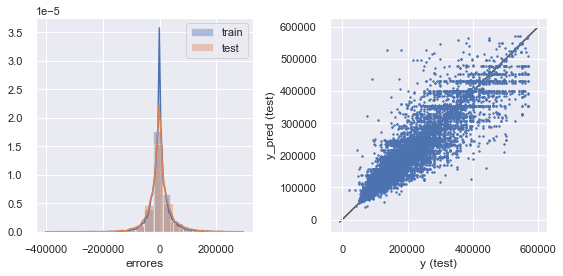

 
Error Promedio: 27070.6817 dias.
Exactitud = 86.11%.


In [33]:
tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=42)
tree_regressor.fit(X_train, y_train)
# estandarizado con tree no importa
evaluar(tree_regressor, X,y, X_train, X_test, y_train, y_test)
accuracy_benchmark = evaluate(X_test, y_test,tree_regressor.predict(X_test))

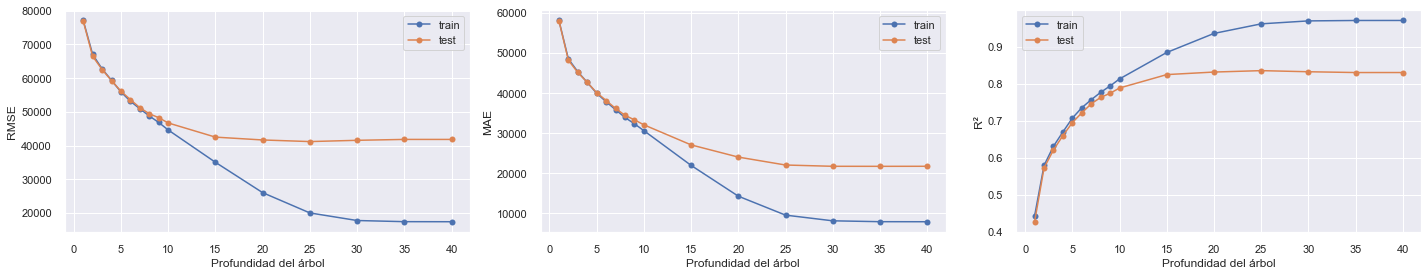

In [27]:
test_hiperparametro('tree', X,y, X_train, X_test, y_train, y_test,[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40])

Podemos ver como a una profundidad de 25 el modelo ya no tiene una mejoria notable del error

## Random Forest
Basado en PyCaret y en los modelos mas conocido y sencillo, se decidio utilizar Random Forest como Model y para optiomizacion de hiperparemetros


Raíz del error cuadrático medio(RMSE) en Train: 20222.6771444583 
Raíz del error cuadrático medio(RMSE) en Test: 35387.53566186597 

Error absoluto medio (MAE) en Train: 11707.979209673402
Error absoluto medio (MAE) en Test: 20401.89273753236
R² en Train: 0.9616555605749986
R² en Test: 0.8786649556172758


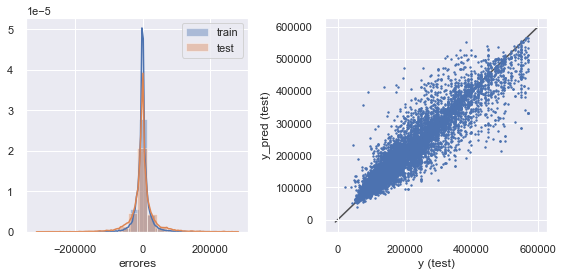

 
Error Promedio: 20401.8927 dias.
Exactitud = 89.46%.


In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)
# estandarizado con tree no importa
evaluar(rf, X,y, X_train, X_test, y_train, y_test)
accuracy_rf = evaluate(X_test, y_test,rf.predict(X_test))

De entrada basandonos principalmente en el RMSE podemos ver como el modelo es mucho mejor al utilizado anteriormento con una diferencia a favor de casi 10.000 unidades en test y en la medida de exactitud podemos ver como hay una mejora de 3.35 puntos

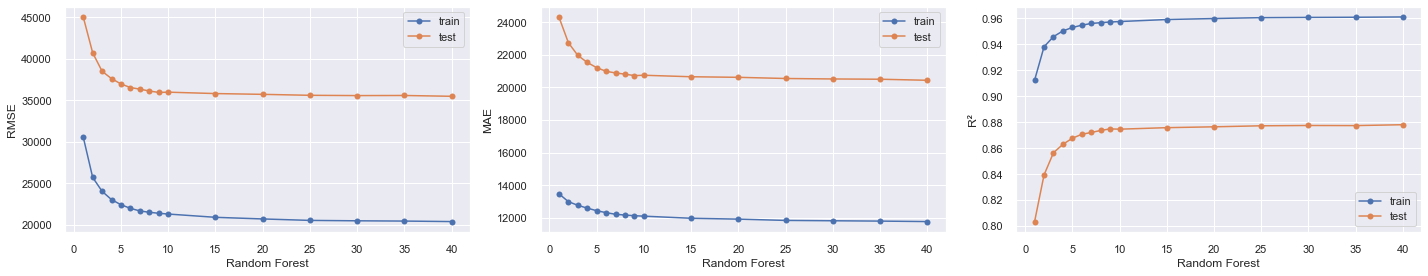

In [37]:
test_hiperparametro('rf', X,y, X_train, X_test, y_train, y_test,[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40])

Podemos ver como aproximadamente a los 10 estimadores no hay una mejoria notable del modelo


Raíz del error cuadrático medio(RMSE) en Train: 21283.962712782126 
Raíz del error cuadrático medio(RMSE) en Test: 35979.480435444115 

Error absoluto medio (MAE) en Train: 12095.390896158542
Error absoluto medio (MAE) en Test: 20748.246475167118
R² en Train: 0.9575253239680113
R² en Test: 0.8745717426369966


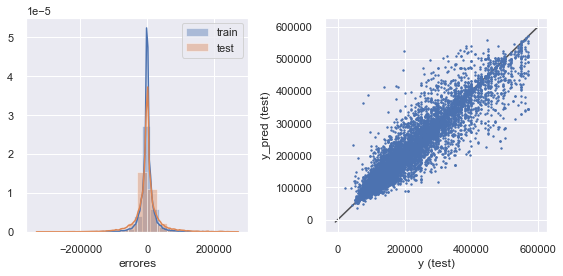

 
Error Promedio: 20748.2465 dias.
Exactitud = 89.33%.


In [38]:
rf_2 = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = 4).fit(X_train,y_train)
# estandarizado con tree no importa
evaluar(rf_2, X,y, X_train, X_test, y_train, y_test)
accuracy_rf = evaluate(X_test, y_test,rf_2.predict(X_test))

Al probar la nueva cantidad de estimadores podemos ver que el error aumenta en una medida muy pequeña pero la velocidad de entrenamiento del mismo aumenta notablemente

## Grid Search

In [47]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 80, 90, 100, 110],
    'n_estimators': [6,7,8,9,10,15,20,25,100]
}
# Create a based model
rf_grid = RandomForestRegressor()
# Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
# Fit the grid search to the data
# grid_search.fit(X_train,y_train)

# grid_search.best_params_

{'max_depth': 90, 'n_estimators': 100}

## Evaluacion Grid Search


Raíz del error cuadrático medio(RMSE) en Train: 20222.6771444583 
Raíz del error cuadrático medio(RMSE) en Test: 35387.53566186597 

Error absoluto medio (MAE) en Train: 11707.979209673402
Error absoluto medio (MAE) en Test: 20401.89273753236
R² en Train: 0.9616555605749986
R² en Test: 0.8786649556172758


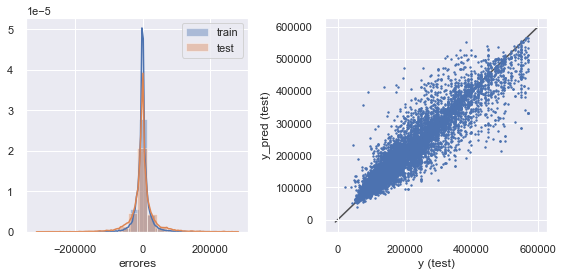

 
Error Promedio: 20401.8927 dias.
Exactitud = 89.46%.


In [45]:
rf_grid_eval = RandomForestRegressor(n_estimators=100, max_depth=90, random_state=42, n_jobs = 4).fit(X_train,y_train)
# estandarizado con tree no importa
evaluar(rf_grid_eval, X,y, X_train, X_test, y_train, y_test)
accuracy_rf = evaluate(X_test, y_test,rf_grid_eval.predict(X_test))

La mejoria es minima, practicamente nula con el primer modelo de este tipo que entrenamos

## PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

9. ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

In [ ]:
# shap_values = shap.TreeExplainer(tree_regressor).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

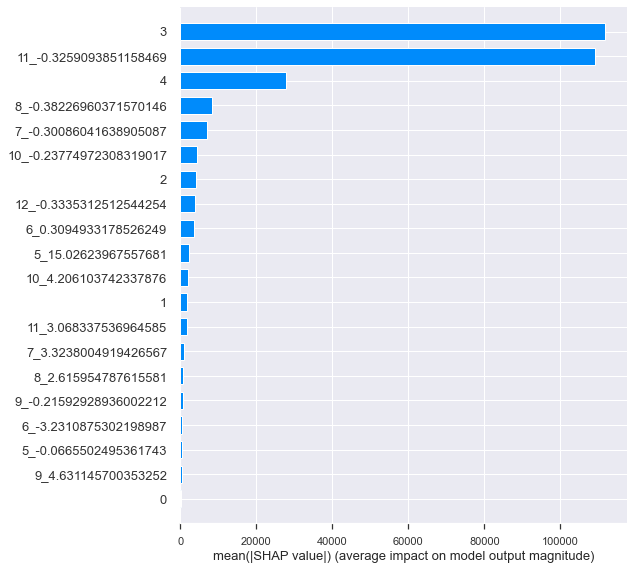

Podemos ver que los componentes mas importantes para el modelo es el 3 y 11 principalmente

10. ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

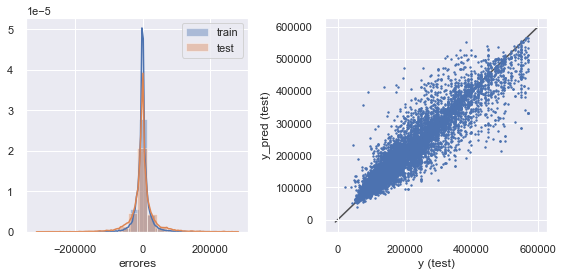

Podemos ver que los errores estan distribuidos de manera cercana a 0, y por otro lado para precios bajos predice mucho mejor que para precios/valores altos

#### Parte C - Mejoras
Para mejor utilizaria mayor informacion que fue descartada como ubicacion, o implementaria NLP para poder usar la informacion del titulo o la descripcionpara poder mejorar el modelo.
Por otro lado me gustarua agregar informacion referida a los barrios, o realizar un analisis mas profunda en la correlacion de precios por barrios, etc.
        
        